In [1]:

import shutil
import numpy as np
import pandas as pd
import os


In [2]:
train_labels = pd.read_csv("./dataset/trainLabels.csv", header="infer") #get train labels


In [3]:
classes = train_labels['label'].unique() #convert them to list of classes
print(classes)

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']


In [6]:
#This part is needed to organize all pictures into folders under their real label, as preprocessing step
if not os.path.exists("./dataset/valid"):
    os.mkdir("./dataset/valid")
    
parent_path_train = "./dataset/train"
parent_path_valid = "./dataset/valid"
parent_path_test = "./dataset/test"

for class1 in classes:
    path_train = os.path.join(parent_path_train,class1)
    if not os.path.exists(path_train):
        os.mkdir(path_train)
    path_valid = os.path.join(parent_path_valid,class1)
    if not os.path.exists(path_valid):
        os.mkdir(path_valid)
        
for (int_ind,row) in train_labels.iterrows():
    id = str(row["id"])+".png"
    source_path = os.path.join(parent_path_train,id)
    
    p=np.random.random()
    if p<=0.8:
        target_path = os.path.join(parent_path_train,row["label"],id)
        os.replace(source_path, target_path)
    else:
        target_path = os.path.join(parent_path_valid,row["label"],id)
        os.replace(source_path, target_path)

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

#Define data transoframtions for preprocessing as well
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(32), #Flip and resize for care
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

#Create datasets using ImageFolder
train_dataset = ImageFolder(root='./dataset/train/', transform=train_transform)
valid_dataset = ImageFolder(root='./dataset/valid/', transform=valid_transform)

#Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)


In [5]:
#Print dataset statistics
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

#Print the shape of a sample image
sample_image, sample_label = next(iter(train_loader))
print(f"Shape of a sample image: {sample_image.shape}")

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of training samples: 40025
Number of validation samples: 9975
Shape of a sample image: torch.Size([128, 3, 32, 32])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Complex Custom CNN model which try first
#Apparantely it is too complex but looks fun
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(48)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(64, 80, kernel_size=3, stride=1, padding=0, bias=False)
        self.batchnorm4 = nn.BatchNorm2d(80)
        self.relu4 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(80, 96, kernel_size=3, stride=1, padding=0, bias=False)
        self.batchnorm5 = nn.BatchNorm2d(96)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=0, bias=False)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.relu6 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(61952, 64)
        self.batchnorm7 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 10)
        self.batchnorm8 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batchnorm1(self.conv1(x))))
        x = self.dropout2(self.relu2(self.batchnorm2(self.conv2(x))))
        x = self.relu3(self.batchnorm3(self.conv3(x)))
        x = self.dropout3(self.relu4(self.batchnorm4(self.conv4(x))))
        x = self.relu5(self.batchnorm5(self.conv5(x)))
        x = self.dropout4(self.relu6(self.batchnorm6(self.conv6(x))))
        x = self.flatten(x)
        x = self.dropout5(self.batchnorm7(self.fc1(x)))
        x = self.batchnorm8(self.fc2(x))

        return x




In [11]:
class CustomCNN2(nn.Module):

    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CustomCNN2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)
        
  
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)


        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        
    
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)
        

        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)

    def forward(self, x):
        
        x = self.drop_conv(self.maxpool1(self.conv1_bn(self.cnn1(x))))
        x = self.drop_conv(self.maxpool2(torch.relu(self.conv2_bn(self.cnn2(x)))))
        x = self.drop_conv(self.maxpool3(torch.relu(self.conv3_bn(self.cnn3(x)))))
        x = self.fc1_bn(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2_bn(self.fc2(F.relu(self.drop(x))))
        x = self.fc3_bn(self.fc3(F.relu(self.drop(x))))
        x = self.fc4_bn(self.fc4(F.relu(self.drop(x))))
        x = self.fc5_bn(self.fc5(F.relu(self.drop(x))))
        
        return(x)

Batch 1:
Data shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


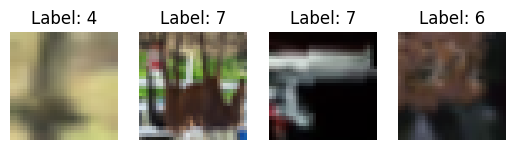

Batch 2:
Data shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


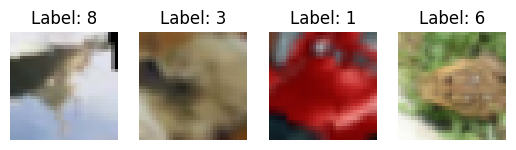

Batch 3:
Data shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


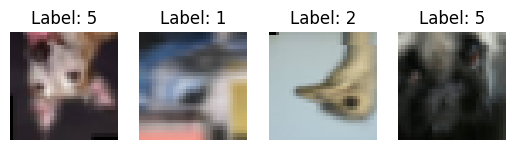

In [8]:
import torch
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

for batch_idx, (data, labels) in enumerate(train_loader):
    #Print information about the batch
    print(f"Batch {batch_idx + 1}:")
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    
    #Visualize a few images from the batch
    num_images_to_visualize = min(data.size(0), 4)
    to_pil = ToPILImage()
    
    for i in range(num_images_to_visualize):
        image = to_pil(data[i])
        label = labels[i].item()
        
        plt.subplot(1, num_images_to_visualize, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")
    
    plt.show()
    
    if batch_idx == 2:
        break


In [9]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")



CUDA Available: False


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Assuming you have already defined train_loader and valid_loader
# Also, assuming you have a function compute_accuracy(outputs, labels) to compute accuracy

# Instantiate the model
model = CustomCNN2()
device = "cpu"
# Set device (GPU if available, else CPU)
if(torch.cuda.is_available()):
    device = torch.device("cuda")
model.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop with tqdm progress bar
num_epochs = 128

# Lists to store training and validation loss
train_losses = []
valid_losses = []

# Lists to store training and validation accuracy
train_accuracies = []
valid_accuracies = []

early_stopping = 0
best_acc = 0
patience = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap train_loader with tqdm for the progress bar
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    valid_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    accuracy = correct_preds / total_samples
    valid_accuracies.append(accuracy)
    
    if best_acc < accuracy:
        best_acc = accuracy
        early_stopping = 0
    else:
        early_stopping +=1 
        
    if early_stopping >= patience:
        break

    # Print and plot the results
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Accuracy: {accuracy}")

# Plotting
plt.figure(figsize=(12, 4))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/128:  19%|█▉        | 61/313 [00:21<01:26,  2.90batch/s]


KeyboardInterrupt: 

In [55]:
import os
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize(32),  # Adjust size as needed
    transforms.ToTensor(),
])

#make test data loader as was done for training dataset
test_dataset = ImageFolder(root='./dataset/test_folder', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#go into evaluation mode
model.eval()

predictions = []

#Get numerical filenames from the dataset
numerical_file_names = [int(os.path.splitext(os.path.basename(path))[0]) for path, _ in test_dataset.imgs]

#Make predictions on the test set
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

#Convert class indices to class names
class_names = [train_dataset.classes[i] for i in predictions]

#Create a DataFrame with 'id' and 'label' columns
df = pd.DataFrame({
    'id': numerical_file_names,
    'label': class_names
})

#Sort the DataFrame by 'id'
df = df.sort_values(by='id')

#Save the DataFrame to a CSV file
df.to_csv('predictionsNEWCNN3.csv', index=False)

print("Predictions are saved")


Predictions are saved
